# New York City Taxi Trip Duration

The competition dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should **predict the duration of each trip in the test set.**

### File descriptions

**train.csv** - the training set (contains 1458644 trip records)  
**test.csv** - the testing set (contains 625134 trip records)  
**sample_submission.csv** - a sample submission file in the correct format  

### Data fields

**id** - a unique identifier for each trip  
**vendor_id** - a code indicating the provider associated with the trip record  
**pickup_datetime** - date and time when the meter was engaged  
**dropoff_datetime** - date and time when the meter was disengaged  
**passenger_count** - the number of passengers in the vehicle (driver entered value)  
**pickup_longitude** - the longitude where the meter was engaged  
**pickup_latitude** - the latitude where the meter was engaged  
**dropoff_longitude** - the longitude where the meter was disengaged  
**dropoff_latitude** - the latitude where the meter was disengaged  
**store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server  
Y=store and forward; N=not a store and forward trip  
**trip_duration** - duration of the trip in seconds  

*Disclaimer: The decision was made to not remove dropoff coordinates from the dataset order to provide an expanded set of variables to use in Kernels.*

## Data Loading and Exploration

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

FILEPATH = "datas/"
train = pd.read_csv(FILEPATH + "train.csv")
testfile = pd.read_csv(FILEPATH + "test.csv")
train.head(6)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443


In [2]:
train.info()
correlations_data = train.corr()['trip_duration'].sort_values()
correlations_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


pickup_latitude     -0.029204
dropoff_latitude    -0.020677
passenger_count      0.008471
dropoff_longitude    0.014678
vendor_id            0.020304
pickup_longitude     0.026542
trip_duration        1.000000
Name: trip_duration, dtype: float64

## Data Cleaning

We have 1458644 rows for each column so there are no missing values.

In [3]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


We clearly see `trip_duration` takes strange values for `min` and `max`. Let's have a quick visualisation with a boxplot.

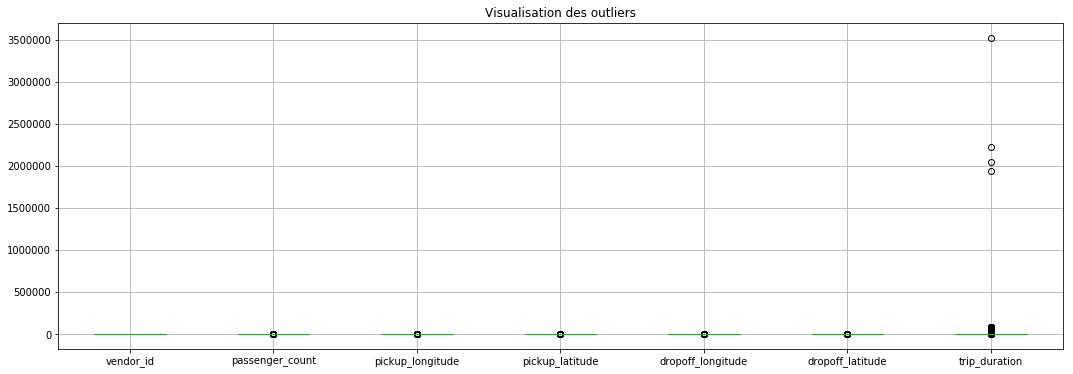

In [4]:
plt.subplots(figsize=(18,6))
plt.title("Visualisation des outliers")
train.boxplot();

There are outliers for `trip_duration`. I can't find a proper interpretation and it will probably damage our model, so I choose to get rid of them. We will only keep what I assume to be legit trips, i.e. between 100 and 10000 seconds.

In [5]:
#We only keep rows with a trip_duration between 100 and 10000 seconds.
train = train[(train.trip_duration < 10000) & (train.trip_duration > 100)]

## Features engineering (selection & transformations)

First of all, let's select the features we need to make our predicting model.  
`id` is unique and linked to a specific trip so there's not point in keeping it in our model. `store_and_fwd_flag` is not relevant to make predictions as I assume that vehicle memories work well and that it don't change the trip duration.

In [6]:
#Removing 'id' and store_and_fwd_flag' columns
train.drop(['id'], axis=1, inplace=True)
train.drop(['store_and_fwd_flag'], axis=1, inplace=True)
testfile.drop(['store_and_fwd_flag'], axis=1, inplace=True)

#### Deal with dates

In [7]:
#Datetyping the dates so we can work with it
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
testfile['pickup_datetime'] = pd.to_datetime(testfile.pickup_datetime)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437232 entries, 0 to 1458643
Data columns (total 9 columns):
vendor_id            1437232 non-null int64
pickup_datetime      1437232 non-null datetime64[ns]
dropoff_datetime     1437232 non-null object
passenger_count      1437232 non-null int64
pickup_longitude     1437232 non-null float64
pickup_latitude      1437232 non-null float64
dropoff_longitude    1437232 non-null float64
dropoff_latitude     1437232 non-null float64
trip_duration        1437232 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 109.7+ MB


Now that we can work with our dates, we are going to create relevant date features for our model. We'll store the week, the weekday and the hour in our dataframe.

In [8]:
#Date features creations and deletions
train['week'] = train.pickup_datetime.dt.week
train['weekday'] = train.pickup_datetime.dt.weekday
train['hour'] = train.pickup_datetime.dt.hour
train.drop(['pickup_datetime'], axis=1, inplace=True)
train.drop(['dropoff_datetime'], axis=1, inplace=True)
testfile['week'] = testfile.pickup_datetime.dt.week
testfile['weekday'] = testfile.pickup_datetime.dt.weekday
testfile['hour'] = testfile.pickup_datetime.dt.hour
testfile.drop(['pickup_datetime'], axis=1, inplace=True)

Now that we have our features, we can take a look at our target.

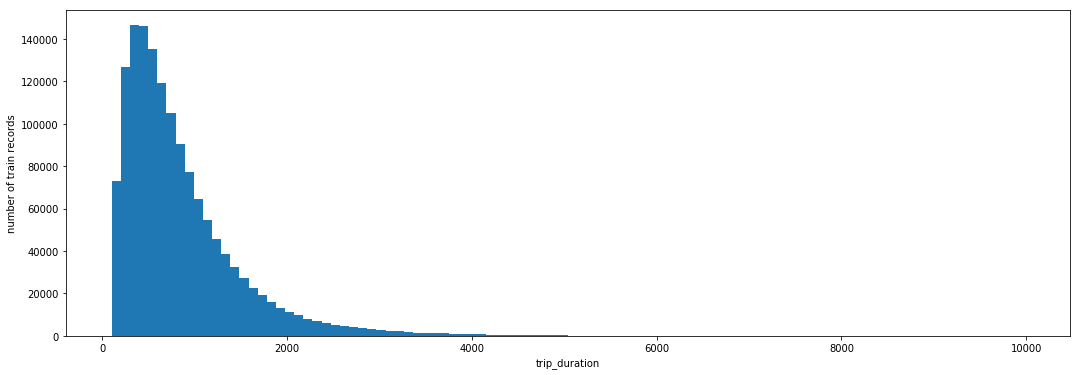

In [9]:
#Visualising the distribution of trip_duration values
plt.subplots(figsize=(18,6))
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

The distribution is right-skewed so we can consider a log-transformation of `trip_duration` data.

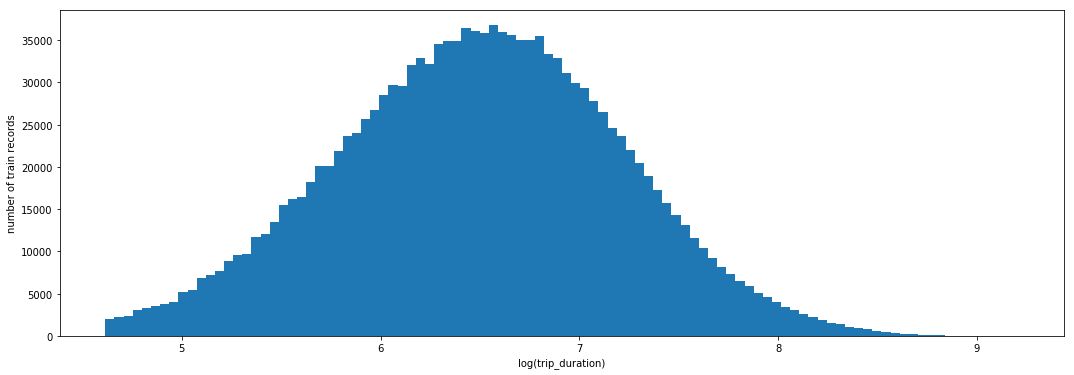

In [10]:
#Log transformation
plt.subplots(figsize=(18,6))
train['trip_duration'] = np.log(train['trip_duration'].values) #+1 is not needed here as our trip_duration values are all positive and not normalized. But it would be necessary to normalize and add 1 to make a robust code for new data.
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

## Model Selection and Training

In [11]:
y = train["trip_duration"]
train.drop(["trip_duration"], axis=1, inplace=True)
X = train
X.shape, y.shape

((1437232, 9), (1437232,))

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1149785, 9), (1149785,), (287447, 9), (287447,))

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((862338, 9), (862338,), (287447, 9), (287447,))

In [14]:
from sklearn.ensemble import RandomForestRegressor

#The randomforestregressor params are chosen in the following hyperparameters tuning
m1 = RandomForestRegressor(n_estimators=19, min_samples_split=2, min_samples_leaf=4, max_features='auto', max_depth=80, bootstrap=True)
m1.fit(X_train, y_train)
m1.score(X_valid, y_valid)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.7950239016281706

In [15]:
#from sklearn.ensemble import GradientBoostingRegressor

#gradient_boosted = GradientBoostingRegressor()
#gradient_boosted.fit(X_train, y_train)
#gradient_boosted.score(X_valid, y_valid)

#score: around 0.5

In [16]:
from sklearn.metrics import mean_squared_error as MSE

print(np.sqrt(MSE(y_valid, m1.predict(X_valid))))
#print(np.sqrt(MSE(y_valid, gradient_boosted.predict(X_valid))))
#around 0.63 for GBR

0.3216651540715255


RandomForestRegressor seems to fit better than GradientBoostingRegressor. Now here is how I chose the RFR hyperparameters.

### Hyperparameters tuning

We are going to look at the better combination of hyperparameters using RandomizedSearchCV. It took me 138.2min to run this cell so be patient if you're using it.

In [17]:
#from sklearn.model_selection import RandomizedSearchCV

#n_estimators = [int(x) for x in np.linspace(start = 5, stop = 20, num = 16)]
#max_features = ['auto', 'sqrt']
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
#min_samples_split = [2, 5, 10]
#min_samples_leaf = [1, 2, 4]
#bootstrap = [True, False]

#random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

#random_cv = RandomizedSearchCV(estimator = m1, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#print(random_cv.best_params_)

## Predictions and Submission

In [18]:
test_columns = X_train.columns
predictions = m1.predict(testfile[test_columns])

In [19]:
my_submission = pd.DataFrame({'id': testfile.id, 'trip_duration': np.exp(predictions)})
my_submission.head()

,id,trip_duration
0,id3004672,812.320879
1,id3505355,733.461013
2,id1217141,454.176576
3,id2150126,918.611488
4,id1598245,344.713630


In [20]:
my_submission.to_csv(FILEPATH + "sub2.csv", index=False)